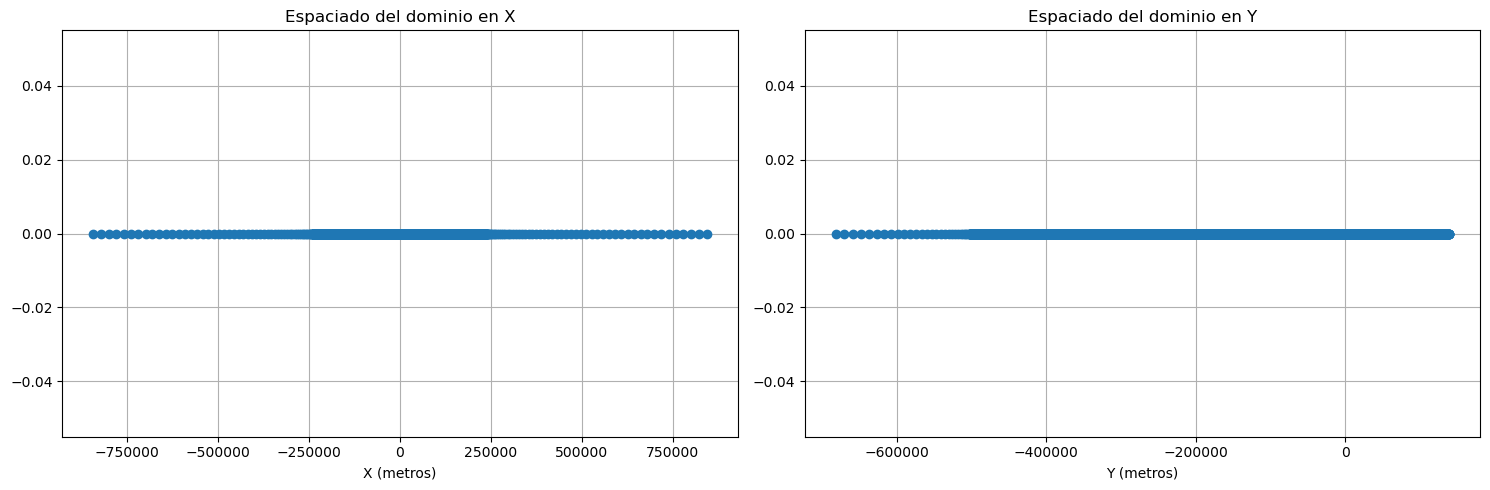

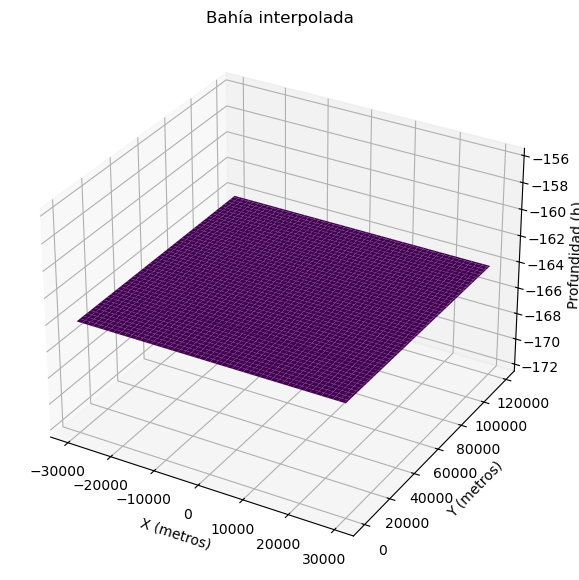

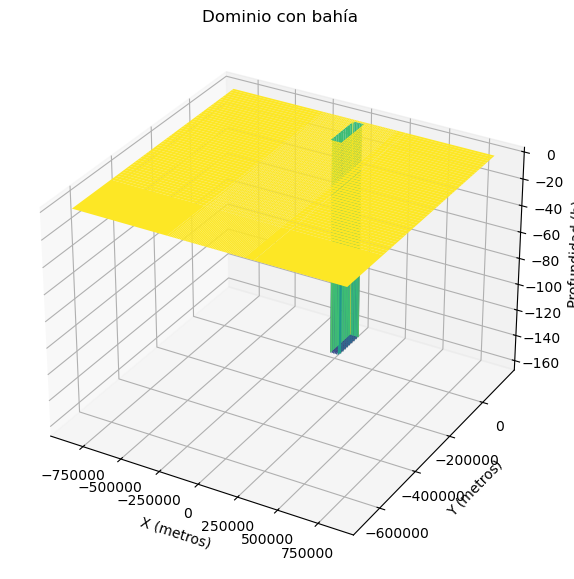

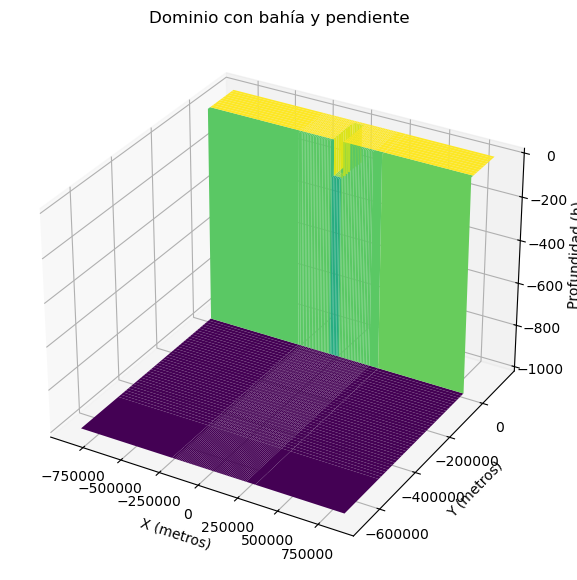

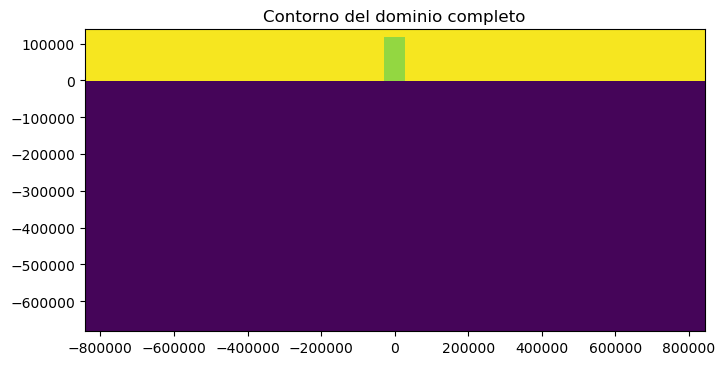

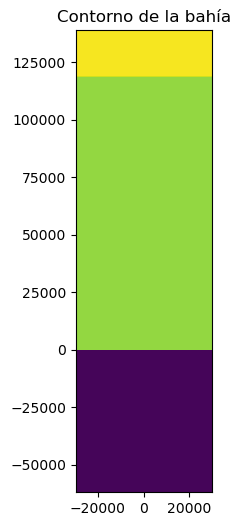

Datos guardados exitosamente en bahia01_expand_bat.nc
1.0, 1.0, 1.1, 1.1, 1.2, 1.2, 1.3, 1.3, 1.4, 1.5, 
1.5, 1.6, 1.7, 1.7, 1.8, 1.9, 2.0, 2.0, 2.1, 
2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.9, 3.0, 3.1, 
3.2, 3.4, 3.5, 3.7, 3.8, 4.0, 4.2, 4.4, 4.5, 
4.7, 4.9, 5.2, 5.4, 5.6, 5.8, 6.1, 6.4, 6.6, 
6.9, 7.2, 7.5, 7.8, 8.2, 8.5, 8.9, 9.3, 9.7, 
10.1, 10.5, 11.0, 11.4, 11.9, 12.5, 13.0, 13.5, 14.1, 
14.7, 15.4, 16.0, 16.7, 17.4, 18.2, 19.0, 19.8, 20.6, 
21.5, 22.4, 23.4, 24.4, 25.4, 26.5, 27.7, 28.9, 30.1, 
31.4, 32.7, 34.2, 35.6, 37.1, 38.7, 40.5, 42.2, 
Suma total (aprox): 1000.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import netCDF4 as nc

# =============================================================================
# Función para definir y retornar los parámetros básicos
# =============================================================================
def get_parameters():
    # Parámetros del dominio y batimetría
    h1 = 164 
    L = 119000 
    Y_fondo = -62000
    Fondo_lineal = -440000
    Costa_extra = 20000
    L_expansion = 2 * L
    DelX = 200  # Espaciado en X
    DelY = 200  # Espaciado en Y

    # Cálculo de la cantidad de puntos en la parte central
    nx_center = int(4 * L / DelX)
    ny = int((L + Costa_extra + np.abs(Y_fondo) + np.abs(Fondo_lineal)) / DelY)
    
    # Índice inicial para la pendiente (usado luego)
    idx_start_slope = int(440000 / DelY)
    
    # Se retorna además los parámetros para la expansión de dominio
    return {
        'h1': h1, 'L': L, 'Y_fondo': Y_fondo, 'Fondo_lineal': Fondo_lineal,
        'Costa_extra': Costa_extra, 'L_expansion': L_expansion,
        'DelX': DelX, 'DelY': DelY, 'nx_center': nx_center, 'ny': ny,
        'idx_start_slope': idx_start_slope, 'ny_expand': 30
    }

# =============================================================================
# Función para crear el dominio completo (X e Y) y su malla
# =============================================================================
def create_domain(params):
    h1 = params['h1']
    L = params['L']
    Y_fondo = params['Y_fondo']
    Fondo_lineal = params['Fondo_lineal']
    Costa_extra = params['Costa_extra']
    L_expansion = params['L_expansion']
    DelX = params['DelX']
    DelY = params['DelY']
    nx_center = params['nx_center']
    ny = params['ny']
    ny_expand = params['ny_expand']
    
    # Definir rangos para el dominio central y de expansión
    x_min_center = -L_expansion
    x_max_center = L_expansion
    y_min = -int(np.abs(Y_fondo) + 440000)
    
    # Regiones de expansión en X y Y usando crecimiento cuadrático
    k = DelX  # Factor para crecimiento cuadrático
    i_values_x = np.arange(56)
    x_right = x_max_center + (k * i_values_x**2)
    x_left = -np.flip(x_right)
    
    i_values_y = np.arange(ny_expand + 1)
    y_expand = y_min - (DelY * i_values_y**2)
    y_expand = np.flip(y_expand)
    
    # Eliminar valores superpuestos
    x_left = x_left[:-1]
    x_right = x_right[1:]
    y_expand = y_expand[:-1]
    
    # Dominio central con espaciado uniforme
    x_center = np.linspace(x_min_center, x_max_center, nx_center)
    y_center = np.linspace(Y_fondo + Fondo_lineal, L + Costa_extra, ny)
    
    # Combinar regiones para formar el dominio completo
    x_domain = np.concatenate((x_left, x_center, x_right))
    y_domain = np.concatenate((y_expand, y_center))
    
    # Crear malla 2D y dominio inicial Z (todo en cero)
    X_domain, Y_domain = np.meshgrid(x_domain, y_domain)
    Z_domain = np.zeros_like(X_domain)
    
    return x_domain, y_domain, X_domain, Y_domain, Z_domain, x_left, x_center, x_right, y_expand

# =============================================================================
# Función para graficar el espaciado de los dominios en X y Y
# =============================================================================
def plot_domain_spacing(x_domain, y_domain):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(x_domain, np.zeros_like(x_domain), 'o-')
    ax1.set_title("Espaciado del dominio en X")
    ax1.set_xlabel("X (metros)")
    ax1.grid(True)
    
    ax2.plot(y_domain, np.zeros_like(y_domain), 'o-')
    ax2.set_title("Espaciado del dominio en Y")
    ax2.set_xlabel("Y (metros)")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Función para calcular la batimetría de la bahía en coordenadas polares y
# su interpolación en un dominio cartesiano refinado
# =============================================================================
def compute_bahia(h1, L, DelX, DelY):
    """
    Construye la batimetría de una bahía rectangular de dimensión L y profundidad h1.
    La dirección X se define de -L/4 a L/4 y la dirección Y se extiende de 0 a L.
    La profundidad es constante (-h1).
    """
    # Calcular el número de puntos en cada dirección basados en el espaciado.
    # Para la dirección x, el rango es L/2 (de -L/4 a L/4)
    nx = int((L/2) / DelX)
    # Para la dirección y, el rango es L (de 0 a L)
    ny = int(L / DelY)
    
    # Definir las coordenadas según el nuevo rango
    x = np.linspace(-L/4, L/4, nx)
    y = np.linspace(0, L, ny)
    X, Y = np.meshgrid(x, y)
    
    # Asignar una profundidad constante a toda la bahía.
    Z_bahia = -np.full_like(X, h1)
    
    return X, Y, Z_bahia


# =============================================================================
# Función para insertar la bahía calculada en el dominio global
# =============================================================================
def insert_bahia(Z_domain, Z_bahia, x_domain, DelX, ny_expand, Y_fondo, Fondo_lineal, L, DelY):
    # Calcular índices en X para ubicar la bahía en el dominio global
    X_idx_start_bahia =  len(x_domain)//2 - int((L/4) / DelX)
    X_idx_end = X_idx_start_bahia + Z_bahia.shape[1]+1 
    
    # Calcular el índice en Y para la bahía
    Idx_bahia_start = ny_expand + int(np.abs(Y_fondo + Fondo_lineal) / DelY) - 1
    Y_idx_end_bahia = Idx_bahia_start + Z_bahia.shape[0]

    Z_domain[Idx_bahia_start:Y_idx_end_bahia, X_idx_start_bahia:X_idx_end] = -164
    
    #Z_domain[Idx_bahia_start:Y_idx_end_bahia, X_idx_start_bahia:X_idx_end] = Z_bahia
    return Z_domain, X_idx_start_bahia, X_idx_end, Idx_bahia_start

# =============================================================================
# Función para agregar el fondo al dominio
# =============================================================================
def add_bottom(Z_domain, Idx_bahia_start):
    # Se asigna un valor fijo en la parte superior
    Z_domain[:Idx_bahia_start+1, :] = -1000
    return Z_domain

# =============================================================================
# Funciones de graficación
# =============================================================================
def plot_3d_surface(X, Y, Z, title='Surface'):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('X (metros)')
    ax.set_ylabel('Y (metros)')
    ax.set_zlabel('Profundidad (h)')
    ax.set_title(title)
    plt.show()

def plot_contours(X, Y, Z, title="Contour Plot"):
    fig, ax = plt.subplots(figsize=(8, 6))
    cf = ax.contourf(X, Y, Z, 33, cmap='viridis')
    ax.contour(X, Y, Z, levels=np.arange(0, 1600, 50), colors='k')
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.show()

# =============================================================================
# Función para suavizar y recortar la batimetría
# =============================================================================
def crop(Z_domain, crop_value=-1000):

    Z_domain_crop = np.where(Z_domain >= crop_value, Z_domain, crop_value)
    return Z_domain_crop

# =============================================================================
# Función para guardar los datos en un archivo NetCDF
# =============================================================================
def save_netcdf(filename, X, Y, Z):
    ny, nx = X.shape
    bahia = nc.Dataset(filename, 'w', format='NETCDF4')
    
    # Definir dimensiones
    bahia.createDimension('x', nx)
    bahia.createDimension('y', ny)
    
    # Crear variables
    x_var = bahia.createVariable('X', np.float32, ('y', 'x'))
    y_var = bahia.createVariable('Y', np.float32, ('y', 'x'))
    z_var = bahia.createVariable('Z', np.float32, ('y', 'x'))
   #z_smooth_var = bahia.createVariable('Z_sm', np.float32, ('y', 'x'))
    
    # Atributos
    x_var.units = 'meters'
    y_var.units = 'meters'
    z_var.units = 'meters'
    #z_smooth_var.units = 'meters'
    x_var.description = 'Coordenadas X del dominio'
    y_var.description = 'Coordenadas Y del dominio'
    z_var.description = 'Datos de profundidad del dominio Z'
    #z_smooth_var.description = 'Datos suavizados de profundidad del dominio Z'
    
    # Asignar datos
    x_var[:, :] = X
    y_var[:, :] = Y
    z_var[:, :] = Z
    #z_smooth_var[:, :] = Z_sm
    
    bahia.close()
    print(f"Datos guardados exitosamente en {filename}")

# =============================================================================
# Función para calcular los niveles verticales y mostrar el vector de espesores (delR)
# =============================================================================
def compute_vertical_levels(total_depth=1000, nz=90, initial_dz=1, factor=1.04293):
    dz = np.zeros(nz)
    dz[0] = initial_dz
    for ii in range(1, nz):
        dz[ii] = dz[ii-1] * factor
    z_levels = np.cumsum(dz)
    # Forzar que el último nivel sea exactamente 1000 m
    z_levels[-1] = total_depth
    
    # Ajuste de los dos últimos niveles (como en el código original)
    dz[-2] += 0.1
    dz[-1] += 0.1
    
    # Impresión formateada de los valores
    for ii, d in enumerate(np.round(dz, 1)):
        print(f'{d},', end=" ")
        if (ii != 0) and (ii % 9 == 0):
            print('')
    print("\nSuma total (aprox):", np.sum(np.round(dz, 1)))
    return dz, z_levels

# =============================================================================
# Función principal
# =============================================================================
def main():
    # 1. Obtener parámetros
    params = get_parameters()
    h1, L = params['h1'], params['L']
    Y_fondo, Fondo_lineal = params['Y_fondo'], params['Fondo_lineal']
    DelX, DelY = params['DelX'], params['DelY']
    ny_expand = params['ny_expand']
    
    # Definir Z_max (según el código original)
    Z_max = -1493 - h1  # -1657
    
    # 2. Crear dominio global
    x_domain, y_domain, X_domain, Y_domain, Z_domain, x_left, _, _, _ = create_domain(params)
    
    # Graficar espaciado de los dominios
    plot_domain_spacing(x_domain, y_domain)
    
    # 3. Calcular índices para insertar la bahía y para la pendiente
    Idx_bahia_start = ny_expand + int(np.abs(Y_fondo + Fondo_lineal) / DelY) - 1
    Idx_slope_start = ny_expand + int(np.abs(Fondo_lineal) / DelY) - 1
    
    # 4. Calcular batimetría de la bahía
    X_new, Y_new, Z_bahia = compute_bahia(h1, L, DelX, DelY)
    plot_3d_surface(X_new, Y_new, Z_bahia, title="Bahía interpolada")
    
    # 5. Insertar la bahía en el dominio global
    Z_domain, X_idx_start_bahia, X_idx_end, Idx_bahia_start = insert_bahia(
        Z_domain, Z_bahia, x_domain, DelX, ny_expand, Y_fondo, Fondo_lineal, L, DelY)
    plot_3d_surface(X_domain, Y_domain, Z_domain, title="Dominio con bahía")
    
    # 6. Agregar la pendiente en la región correspondiente
    Z_domain = add_bottom(Z_domain, Idx_bahia_start)
    
    # 7. Suavizar y recortar la batimetría
    Z_domain_crop = crop(Z_domain, crop_value=-1000)
    plot_3d_surface(X_domain, Y_domain, Z_domain_crop, title="Dominio con bahía y pendiente")
    
    # Suavizado más fuerte para contornos
    #Z_smooth = gaussian_filter(Z_domain_crop, sigma=15)
    plot_contours(X_domain, Y_domain, Z_domain_crop, title="Contorno del dominio completo")
    
    # Contorno detallado de la bahía (subdominio)
    plot_contours(
        X_domain[Idx_slope_start:, X_idx_start_bahia:X_idx_end],
        Y_domain[Idx_slope_start:, X_idx_start_bahia:X_idx_end],
        Z_domain_crop[Idx_slope_start:, X_idx_start_bahia:X_idx_end],
        title="Contorno de la bahía"
    )
    
    # 8. Guardar datos en NetCDF
    save_netcdf('bahia01_expand_bat.nc', X_domain, Y_domain, Z_domain_crop)
    
    # 9. Calcular y mostrar niveles verticales (delR)
    dz, z_levels = compute_vertical_levels()

if __name__ == '__main__':
    main()


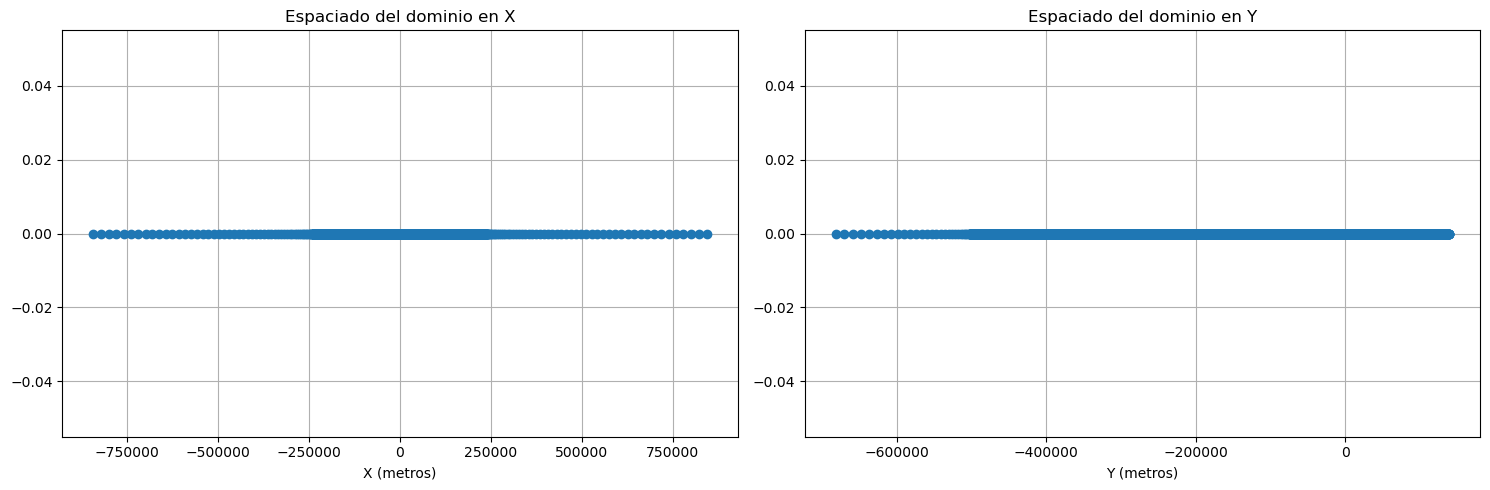

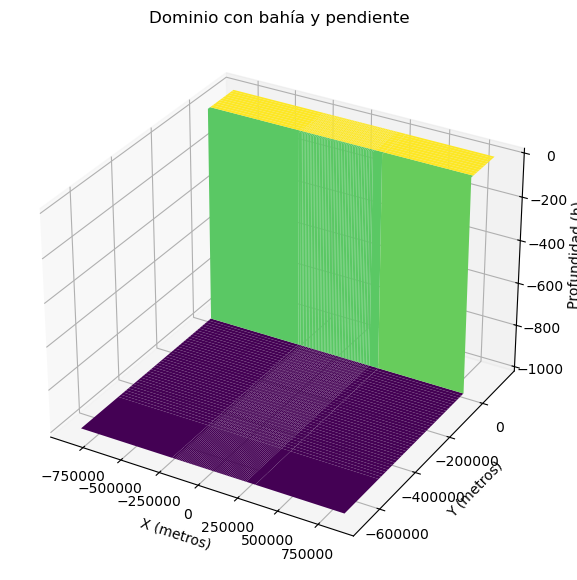

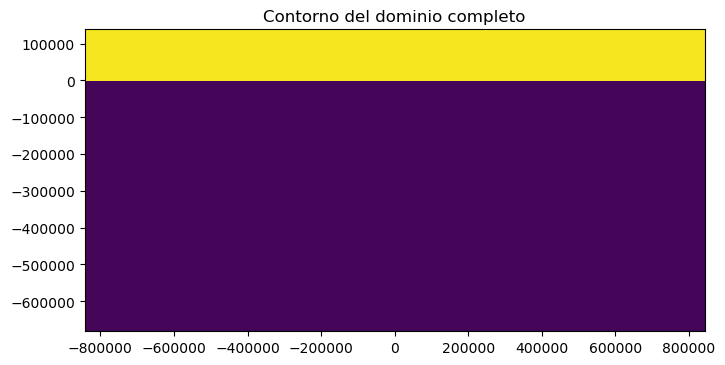

Datos guardados exitosamente en nobay_expand_bat.nc
1.0, 1.0, 1.1, 1.1, 1.2, 1.2, 1.3, 1.3, 1.4, 1.5, 
1.5, 1.6, 1.7, 1.7, 1.8, 1.9, 2.0, 2.0, 2.1, 
2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.9, 3.0, 3.1, 
3.2, 3.4, 3.5, 3.7, 3.8, 4.0, 4.2, 4.4, 4.5, 
4.7, 4.9, 5.2, 5.4, 5.6, 5.8, 6.1, 6.4, 6.6, 
6.9, 7.2, 7.5, 7.8, 8.2, 8.5, 8.9, 9.3, 9.7, 
10.1, 10.5, 11.0, 11.4, 11.9, 12.5, 13.0, 13.5, 14.1, 
14.7, 15.4, 16.0, 16.7, 17.4, 18.2, 19.0, 19.8, 20.6, 
21.5, 22.4, 23.4, 24.4, 25.4, 26.5, 27.7, 28.9, 30.1, 
31.4, 32.7, 34.2, 35.6, 37.1, 38.7, 40.5, 42.2, 
Suma total (aprox): 1000.0


In [2]:
# =============================================================================
# Función principal
# =============================================================================
def main_nobay():
    # 1. Obtener parámetros
    params = get_parameters()
    h1, L = params['h1'], params['L']
    Y_fondo, Fondo_lineal = params['Y_fondo'], params['Fondo_lineal']
    DelX, DelY = params['DelX'], params['DelY']
    ny_expand = params['ny_expand']
    
    # Definir Z_max (según el código original)
    Z_max = -1493 - h1  # -1657
    
    # 2. Crear dominio global
    x_domain, y_domain, X_domain, Y_domain, Z_domain, x_left, _, _, _ = create_domain(params)
    
    # Graficar espaciado de los dominios
    plot_domain_spacing(x_domain, y_domain)
    
    # 3. Calcular índices para insertar la bahía y para la pendiente
    Idx_bahia_start = ny_expand + int(np.abs(Y_fondo + Fondo_lineal) / DelY) - 1
    Idx_slope_start = ny_expand + int(np.abs(Fondo_lineal) / DelY) - 1
    
    # 6. Agregar la pendiente en la región correspondiente
    Z_domain = add_bottom(Z_domain, Idx_bahia_start)
    
     # 7. Suavizar y recortar la batimetría
    Z_domain_crop = crop(Z_domain, crop_value=-1000)
    plot_3d_surface(X_domain, Y_domain, Z_domain_crop, title="Dominio con bahía y pendiente")
    
    # Suavizado más fuerte para contornos
    #Z_smooth = gaussian_filter(Z_domain_crop, sigma=15)
    plot_contours(X_domain, Y_domain, Z_domain_crop, title="Contorno del dominio completo")
    
    
    # 8. Guardar datos en NetCDF
    save_netcdf('nobay_expand_bat.nc', X_domain, Y_domain, Z_domain_crop)
    
    # 9. Calcular y mostrar niveles verticales (delR)
    dz, z_levels = compute_vertical_levels()

if __name__ == '__main__':
    main_nobay()


Variables en el archivo netCDF:
{'X': <class 'netCDF4._netCDF4.Variable'>
float32 X(y, x)
    units: meters
    description: Coordenadas X del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Y': <class 'netCDF4._netCDF4.Variable'>
float32 Y(y, x)
    units: meters
    description: Coordenadas Y del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4._netCDF4.Variable'>
float32 Z(y, x)
    units: meters
    description: Datos de profundidad del dominio Z
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used}
Left x-limit: -843000.0 m, Right x-limit: 843000.0 m
Bottom y-limit: -682000.0 m, Top y-limit: 139000.0 m


/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_32728/3635784627.py:69: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Z)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_32728/3635784627.py:70: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular gr

Forma de la batimetría interpolada: (320, 272)


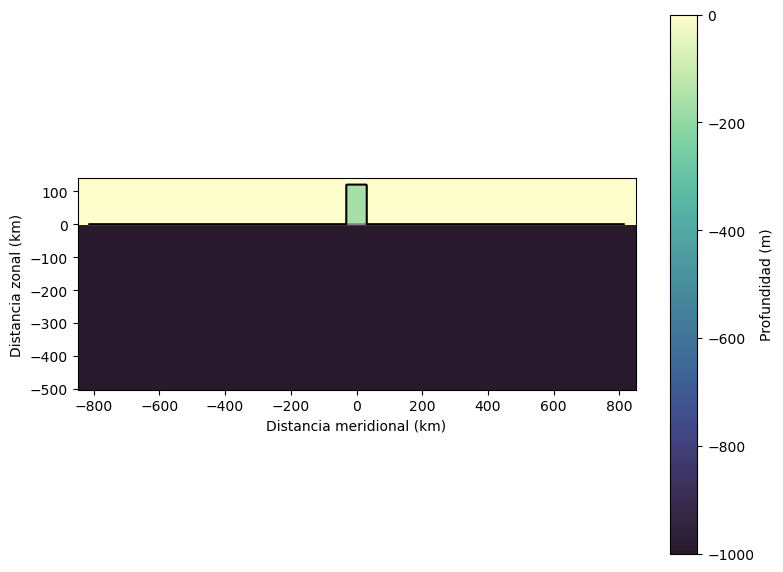

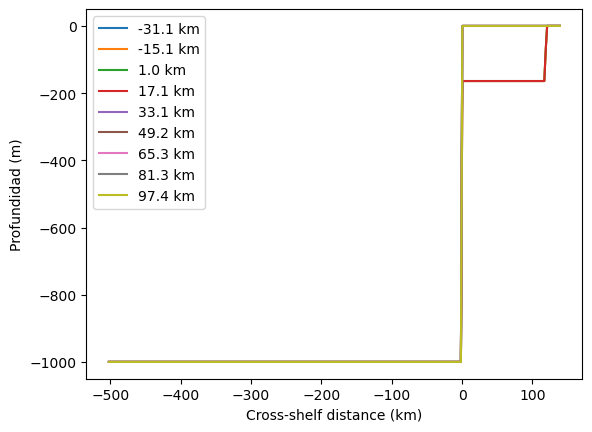

dx: [66000.  62000.  58000.  54000.  50000.  46000.  42000.  38000.  34000.
 30000.  26000.  22000.  18000.  14000.  10000.   6000.   2000.   2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4

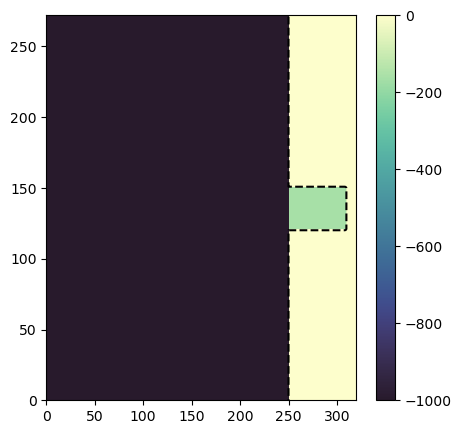

Parámetros MITgcm:
sNx = 17, sNy = 20, OLx = 3, OLy = 3
nSx = 16, nSy = 16, nPx = 1, nPy = 1
Nx = 272
Ny = 320


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cmocean as cmo
import scipy.interpolate as sci_interp

# =============================================================================
# Función para cargar la batimetría original desde el archivo netCDF
# =============================================================================
def load_original_bathy(nc_file):
    """
    Carga la batimetría original desde el archivo netCDF.
    Retorna Xog, Yog y Z (la batimetría suavizada).
    """
    with Dataset(nc_file, 'r') as ds:
        print("Variables en el archivo netCDF:")
        print(ds.variables)
        Xog = ds.variables['X'][:].data
        Yog = ds.variables['Y'][:].data
        Z = ds.variables['Z'][:].data
    print(f'Left x-limit: {np.min(Xog)} m, Right x-limit: {np.max(Xog)} m')
    print(f'Bottom y-limit: {np.min(Yog)} m, Top y-limit: {np.max(Yog)} m')
    return Xog, Yog, Z

# =============================================================================
# Función para construir el nuevo dominio (vectores x y y) con crecimiento cuadrático
# =============================================================================
def build_new_domain(nx_center=238, ny=320, 
                     x_min_center=-238e3, x_max_center=238e3,
                     x_min_expand=-843e3, x_max_expand=843e3,
                     y_min=-62e3-440e3, y_min_expand=-682000, y_max=139e3):
    """
    Construye los vectores de dominio nuevos (x_vect y y_vect) para la batimetría.
    Se utiliza crecimiento cuadrático en las regiones de expansión.
    """
    # Calcular DelX basado en el dominio central (se desea que delX ≈ 2000 m)
    DelX = int((2 * x_max_center) / nx_center)
    k = DelX  # Factor para crecimiento cuadrático

    # Construir las expansiones en X (lado derecho e izquierdo)
    i_values = np.arange(1, int(np.sqrt((x_max_expand - x_max_center) / k)) + 1)
    x_right = x_max_center + k * (i_values**2)
    x_left = -np.flip(x_right)
    
    # Construir la expansión en Y (lado inferior)
    i_values_y = np.arange(1, int(np.sqrt((np.abs(y_min_expand) - np.abs(y_min)) / k)) + 1)
    y_expand = y_min - k * (i_values_y**2)
    y_expand = np.flip(y_expand)
    
    # Dominio central en X y Y
    x_center = np.round(np.linspace(x_min_center, x_max_center, nx_center), decimals=1)
    y_center = np.round(np.linspace(y_min, y_max, ny), decimals=1)
    
    # Unir las regiones para formar los vectores completos
    x_vect = np.concatenate((x_left, x_center, x_right))
    y_vect = np.concatenate((y_expand, y_center))
    
    return x_vect, y_vect, DelX

# =============================================================================
# Función para interpolar la batimetría al nuevo dominio
# =============================================================================
def interpolate_bathy(Xog, Yog, Z, x_vect, y_vect, crop_rows=9):
    """
    Interpola la batimetría original (Z) a los nuevos vectores (x_vect, y_vect)
    usando interp2d de SciPy. Luego se recorta la matriz para obtener las
    dimensiones deseadas (nx=272 y ny=320).
    """
    f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Z)
    bathy = f_interp(x_vect, y_vect)
    # Recortar para ajustar el número de filas (ny)
    bathy = bathy[crop_rows:, :]
    y_vect = y_vect[crop_rows:]
    return bathy, y_vect

# =============================================================================
# Función para graficar la batimetría interpolada
# =============================================================================
def plot_bathy(x_vect, y_vect, bathy, filename=None):
    """
    Grafica la batimetría interpolada usando pcolormesh y contornos.
    Si se proporciona un nombre de archivo, guarda la figura en PNG.
    """
    fig, ax = plt.subplots(figsize=(9,7))
    pc = ax.pcolormesh(x_vect/1000, y_vect/1000, bathy, cmap=cmo.cm.deep_r)
    cb = plt.colorbar(pc, ax=ax)
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='0.5', levels=[250])
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='k', levels=[0])
    cb.set_label('Profundidad (m)')
    ax.set_xlabel('Distancia meridional (km)')
    ax.set_ylabel('Distancia zonal (km)')
    ax.set_aspect(1)
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# =============================================================================
# Función para graficar perfiles transversales (cross-shelf)
# =============================================================================
def plot_cross_shelf_profiles(x_vect, y_vect, bathy, start=120, stop=186, step=8):
    """
    Grafica perfiles transversales a partir de índices especificados, mostrando
    la variación de la batimetría a lo largo de la dirección cross-shelf.
    """
    for ii in range(start, stop, step):
        plt.plot(y_vect/1e3, bathy[:, ii], label=f'{x_vect[ii]/1e3:1.1f} km')
    plt.legend()
    plt.xlabel('Cross-shelf distance (km)')
    plt.ylabel('Profundidad (m)')
    plt.show()

# =============================================================================
# Función para calcular los vectores de espaciado (dx y dy)
# =============================================================================
def compute_grid_spacing(x_vect, y_vect):
    """
    Calcula los vectores de espaciado dx y dy a partir de x_vect y y_vect.
    """
    delx = x_vect[1:] - x_vect[:-1]
    dely = y_vect[1:] - y_vect[:-1]
    dx = np.append(delx, [delx[-1]])
    dy = np.append(dely, [dely[-1]])
    print("dx:", dx)
    print("dy:", dy)
    return dx, dy

# =============================================================================
# Función para guardar los datos en archivos binarios
# =============================================================================
def save_binary_files(dx, dy, bathy, dx_fname, dy_fname, bathy_fname, dt=np.dtype('>f8')):
    """
    Guarda en archivos binarios los vectores de espaciado (dx y dy) y la batimetría.
    """
    with open(dx_fname, 'wb') as f:
        dx.astype(dt).tofile(f, "")
    with open(dy_fname, 'wb') as f:
        dy.astype(dt).tofile(f, "")
    with open(bathy_fname, 'wb') as f:
        bathy.astype(dt).tofile(f, "")
    print(f"Archivos binarios guardados: {dx_fname}, {dy_fname}, {bathy_fname}")

# =============================================================================
# Función para verificar la correcta escritura del archivo binario de batimetría
# =============================================================================
def verify_binary_file(bathy_fname, x_vect, y_vect, dt=np.dtype('>f8')):
    """
    Lee el archivo binario de batimetría, lo reestructura y lo grafica para
    verificar que se haya guardado correctamente.
    """
    cc = np.fromfile(bathy_fname, dtype=dt)
    nx = len(x_vect)
    ny = len(y_vect)
    bF = np.reshape(cc, (nx, ny), order='F')  # Orden Fortran
    fig, ax = plt.subplots(figsize=(5,5))
    pc = ax.pcolormesh(bF, cmap=cmo.cm.deep_r)
    plt.colorbar(pc, ax=ax)
    ax.contour(bF, levels=[-20, 0], colors='k')
    plt.show()

# =============================================================================
# Función para imprimir los parámetros del dominio para MITgcm
# =============================================================================
def print_mitgcm_params(sNx=17, sNy=20, OLx=3, OLy=3, nSx=16, nSy=16, nPx=1, nPy=1):
    """
    Calcula y muestra los parámetros del dominio de MITgcm.
    """
    Nx = sNx * nSx * nPx
    Ny = sNy * nSy * nPy
    print("Parámetros MITgcm:")
    print(f"sNx = {sNx}, sNy = {sNy}, OLx = {OLx}, OLy = {OLy}")
    print(f"nSx = {nSx}, nSy = {nSy}, nPx = {nPx}, nPy = {nPy}")
    print(f"Nx = {Nx}")
    print(f"Ny = {Ny}")

# =============================================================================
# Función principal
# =============================================================================
def makebin_bay():
    # Archivo netCDF de batimetría original
    nc_file = 'bahia01_expand_bat.nc'
    
    # 1. Cargar batimetría original
    Xog, Yog, Z = load_original_bathy(nc_file)
    
    # 2. Construir el nuevo dominio
    x_vect, y_vect, DelX = build_new_domain()
    
    # 3. Interpolar la batimetría al nuevo dominio
    bathy, y_vect = interpolate_bathy(Xog, Yog, Z, x_vect, y_vect, crop_rows=9)
    print("Forma de la batimetría interpolada:", bathy.shape)
    
    # 4. Graficar la batimetría interpolada y guardar la figura
    plot_bathy(x_vect, y_vect, bathy, filename="dominio_bath.png")
    
    # 5. Graficar perfiles cross-shelf
    plot_cross_shelf_profiles(x_vect, y_vect, bathy, start=120, stop=186, step=8)
    
    # 6. Calcular vectores de espaciado dx y dy
    dx, dy = compute_grid_spacing(x_vect, y_vect)
    
    # 7. Guardar archivos binarios
    bathy_fname = 'bahia_01_expand_bat.bin'
    dx_fname = 'bahia_01_expand_dx.bin'
    dy_fname = 'bahia_01_expand_dy.bin'
    save_binary_files(dx, dy, bathy, dx_fname, dy_fname, bathy_fname)
    
    # 8. Verificar el archivo binario de batimetría
    verify_binary_file(bathy_fname, x_vect, y_vect)
    
    # 9. Imprimir parámetros del dominio para MITgcm
    print_mitgcm_params()

if __name__ == '__main__':
    makebin_bay()


Variables en el archivo netCDF:
{'X': <class 'netCDF4._netCDF4.Variable'>
float32 X(y, x)
    units: meters
    description: Coordenadas X del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Y': <class 'netCDF4._netCDF4.Variable'>
float32 Y(y, x)
    units: meters
    description: Coordenadas Y del dominio
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4._netCDF4.Variable'>
float32 Z(y, x)
    units: meters
    description: Datos de profundidad del dominio Z
unlimited dimensions: 
current shape = (3235, 2490)
filling on, default _FillValue of 9.969209968386869e+36 used}
Left x-limit: -843000.0 m, Right x-limit: 843000.0 m
Bottom y-limit: -682000.0 m, Top y-limit: 139000.0 m


/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_32728/3635784627.py:69: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Z)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_32728/3635784627.py:70: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular gr

Forma de la batimetría interpolada: (320, 272)


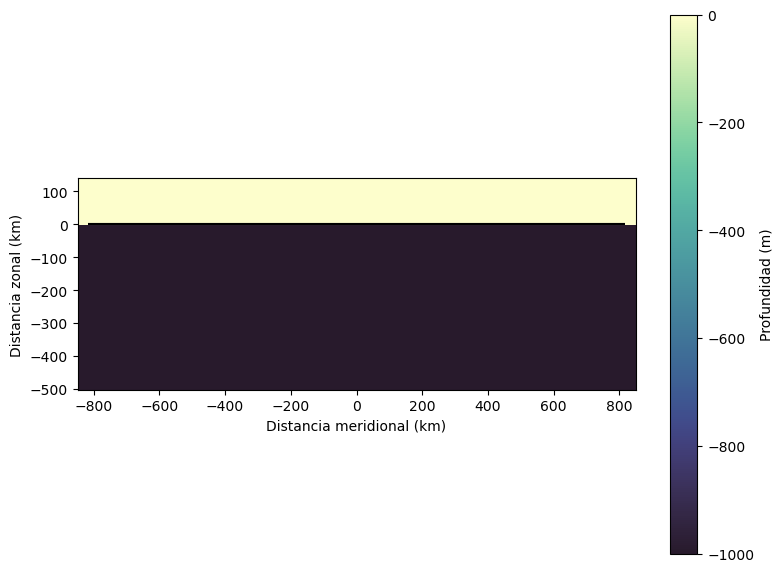

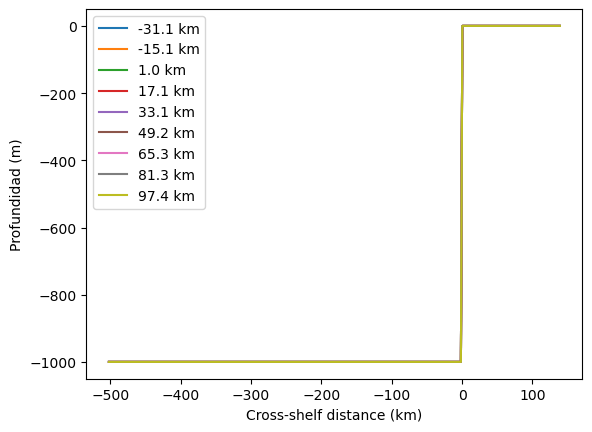

dx: [66000.  62000.  58000.  54000.  50000.  46000.  42000.  38000.  34000.
 30000.  26000.  22000.  18000.  14000.  10000.   6000.   2000.   2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4
  2008.5  2008.4  2008.4  2008.5  2008.4  2008.5  2008.4  2008.4  2008.5
  2008.4  2008.5  2008.4  2008.4  2008.5  2008.4

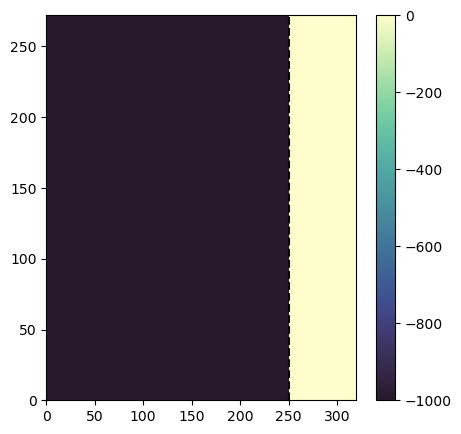

Parámetros MITgcm:
sNx = 17, sNy = 20, OLx = 3, OLy = 3
nSx = 16, nSy = 16, nPx = 1, nPy = 1
Nx = 272
Ny = 320


In [4]:
def makebin_nobay():
    # Archivo netCDF de batimetría original
    nc_file = 'nobay_expand_bat.nc'
    
    # 1. Cargar batimetría original
    Xog, Yog, Z = load_original_bathy(nc_file)
    
    # 2. Construir el nuevo dominio
    x_vect, y_vect, DelX = build_new_domain()
    
    # 3. Interpolar la batimetría al nuevo dominio
    bathy, y_vect = interpolate_bathy(Xog, Yog, Z, x_vect, y_vect, crop_rows=9)
    print("Forma de la batimetría interpolada:", bathy.shape)
    
    # 4. Graficar la batimetría interpolada y guardar la figura
    plot_bathy(x_vect, y_vect, bathy, filename="dominio_bath_nobay.png")
    
    # 5. Graficar perfiles cross-shelf
    plot_cross_shelf_profiles(x_vect, y_vect, bathy, start=120, stop=186, step=8)
    
    # 6. Calcular vectores de espaciado dx y dy
    dx, dy = compute_grid_spacing(x_vect, y_vect)
    
    # 7. Guardar archivos binarios
    bathy_fname = 'nobahia_01_expand_bat.bin'
    dx_fname = 'nobahia_01_expand_dx.bin'
    dy_fname = 'nobahia_01_expand_dy.bin'
    save_binary_files(dx, dy, bathy, dx_fname, dy_fname, bathy_fname)
    
    # 8. Verificar el archivo binario de batimetría
    verify_binary_file(bathy_fname, x_vect, y_vect)
    
    # 9. Imprimir parámetros del dominio para MITgcm
    print_mitgcm_params()

if __name__ == '__main__':
    makebin_nobay()
